In [36]:
import pandas as pd
import plotly.express as px 
import plotly.graph_objects as go
import scikit_posthocs as sp
from scipy import stats
import numpy as np
import seaborn as sns
from statsmodels.nonparametric.kernel_regression import KernelReg
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
import warnings
warnings.filterwarnings('ignore')

## Read Dataframe

In [38]:
dataframe=pd.read_csv("Sample Data.csv")
dataframe.head()

,ID,Start Date,End Date,Site Visits,Site Conversion,Click-through Rate,Bounce Rate,Revenue,Units Sold,Inventory,...,Ad Cost,COGS,Margin,Customer Age,Visitor Type,Satisfaction,Spending Score,Shipping Cost,Discount Rate,Market_Share
0,1,2023-01-01,2023-01-07,15000,800,80,40,50,350,30,...,500,400,0.32,3.00,Young Adults,Occasional Buyers,Neutral,Low,Free Shipping,0.05
1,2,2023-01-08,2023-01-14,16000,840,82,42,51,355,31,...,520,410,0.33,3.10,Adults,Frequent Buyers,Positive,Moderate,Discounts,0.06
2,3,2023-01-15,2023-01-21,14500,780,78,38,49,345,29,...,480,390,0.31,2.95,Seniors,Occasional Buyers,Positive,Low,Free Shipping,0.07
3,4,2023-01-22,2023-01-28,15500,820,80,41,48,360,32,...,510,400,0.32,3.05,Young Adults,Frequent Buyers,Neutral,High,Discounts,0.08
4,5,2023-01-29,2023-02-04,14000,760,76,39,47,340,30,...,470,380,0.30,2.90,Adults,Frequent Buyers,Positive,Moderate,Free Shipping,0.09


In [39]:
print("The Available features are :",list(dataframe.columns))

The Available features are : ['ID', 'Start Date', 'End Date', 'Site Visits', 'Site Conversion', 'Click-through Rate', 'Bounce Rate', 'Revenue', 'Units Sold', 'Inventory', 'Impressions', 'Clicks', 'Ad Cost', 'COGS', 'Margin', 'Customer Age', 'Visitor Type', 'Satisfaction', 'Spending Score', 'Shipping Cost', 'Discount Rate', 'Market_Share']


**Features Interpretation**:
1. **ID**         : Index Column (Dropped)
2. **Start Date** : Week Start Date
3. **End Date**   : Week End Date
4. **Site Visits** : Number of people visiting the website
5. **Site Conversion** : Users who completed certain action on the website
6. **Click-Through Rate** : A metric to measure the effectivenes of advertising campaign. 
<br>  CTR = (Number of Clicks / Number of Impressions) × 100 wher Number of impression is number of times the  Ad was displayed
7. **Bounce Rate** : Visitors bounce away from website after viewing only the landing page
8. **Revenue** : Revenue made at this month. It is assumed to be percentage because it takes value from 44 as minimum to maximum value of 51 (ALTHOUGH Revenue as percentage isn't a technical concept in Business world but it is assumed this way because it can be the only logical explanation of the number to the number
9.  **Units Sold**  : Number of units sold at this month
10. **Inventory**   : Number of products available in the market
11. **Impressions** : Number of Times advertisement is displayed on user screen
12. **Clicks**      : Number of user interactions
13. **Ad Cost**     : Cost of Advertisements per month
14. **COGS**        : Cost of Goods
15. **Margin**      : Differrence between Total Revenues and Total Expenses
16. **Customer Age** : Average customer age, It was taking the value of 2.3, 2.5 ..etc so it was multiplied by 10 to give it a reasonable number
17. **Visitor Type**   : 3 Type  [Adult, Young Adult, Seniors]
18. **Satisfaction**   : 2 Types [Occasional Buyers, Frequent Buyers]
19. **Spending Score** : 2 Types [Neutral, Positive]
20. **Shipping Cost**  : 3 Types [Low,Moderate,High]
21. **Discount Rate**  : 3 Types [Free Shipping, Discounts, Buy One Get One]
22. **Market Share**   : Last Column is unnamed but in previous dataset, last column was set as the Market share so this column aslo is placed as the market share.

## Check Column Data Types and missing Values

In [40]:
#Data Types
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  50 non-null     int64  
 1   Start Date          50 non-null     object 
 2   End Date            50 non-null     object 
 3   Site Visits         50 non-null     int64  
 4   Site Conversion     50 non-null     int64  
 5   Click-through Rate  50 non-null     int64  
 6   Bounce Rate         50 non-null     int64  
 7   Revenue             50 non-null     int64  
 8   Units Sold          50 non-null     int64  
 9   Inventory           50 non-null     int64  
 10  Impressions         50 non-null     int64  
 11  Clicks              50 non-null     int64  
 12  Ad Cost             50 non-null     int64  
 13  COGS                50 non-null     int64  
 14  Margin              50 non-null     float64
 15  Customer Age        50 non-null     float64
 16  Visitor Ty

In [41]:
#Missing Values
dataframe.isna().sum()

ID                    0
Start Date            0
End Date              0
Site Visits           0
Site Conversion       0
Click-through Rate    0
Bounce Rate           0
Revenue               0
Units Sold            0
Inventory             0
Impressions           0
Clicks                0
Ad Cost               0
COGS                  0
Margin                0
Customer Age          0
Visitor Type          0
Satisfaction          0
Spending Score        0
Shipping Cost         0
Discount Rate         0
Market_Share          0
dtype: int64

## Data Cleaning And Preparation

* Drop ID Column as it is similar to index and adds no value

In [42]:
dataframe.drop(columns=["ID"],inplace=True)

* Set Start and End Date to be DateTime object and drop End Date columns becuase Week can be marked by start date only

In [43]:
dataframe['Start Date']= pd.to_datetime(dataframe['Start Date'])
dataframe['End Date']= pd.to_datetime(dataframe['End Date'])
dataframe.drop(columns=["End Date"],inplace=True)

* Set Customer Age to reasonable number 

In [44]:
dataframe["Customer Age"]=dataframe["Customer Age"].apply(lambda x:int(x*10))

## Expolatory Data Analysis

### a.Identify Trends and Patterns in Sales Performance

* We will rely Sales Performance on Number of Units Sold. 


**First Step**: use Kernel Regression to identify initial estimation of underlying Trends in Sales Performance

In [45]:
x_factor=list(dataframe.index)
y_factor=list(dataframe["Units Sold"].values)
kr = KernelReg(y_factor,x_factor,'c') 
y_pred, y_std = kr.fit(x_factor) 
dataframe.loc[:,'Units_Sold_Trend']=  y_pred

**Second Step** : Plot Graph of both Number of Units Sold and Trend of Units Sold

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataframe["Start Date"], y=dataframe["Units_Sold_Trend"],mode='lines',name='Overall Selling Trend'))
fig.add_trace(go.Scatter(x=dataframe["Start Date"], y=dataframe["Units Sold"],mode='lines',name='Number of Sold Units'))
fig.update_layout(
    title=dict(text="Number of Sold Units")
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Number of Sold Units")
fig.show()
dataframe.drop(columns=["Units_Sold_Trend"],inplace=True)

**Third Step** : A more Detailed analysis to identify Trend, Seasonality and Residuals under assumption of a period of 3 Weeks.

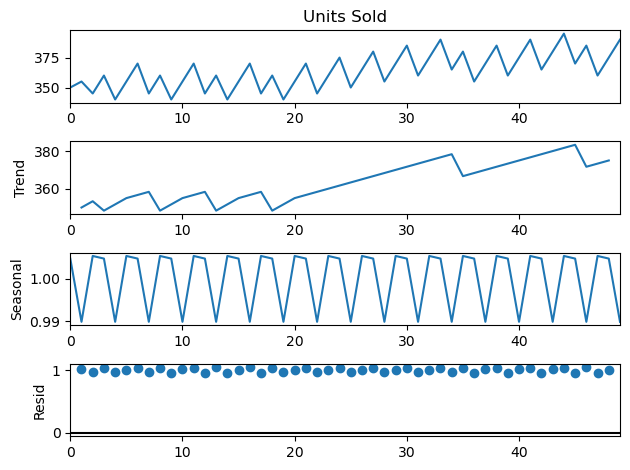

In [47]:

decompose_result_mult = seasonal_decompose(dataframe["Units Sold"], model="multiplicative", period=3)
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
decompose_result_mult.plot();

**Findings**:

* Number of Units Sold follow a general increasing Trend Across the Year with Higher trend starting from Mid Year.
* There is a Clear Seasonality in the data every period of Three Weeks

### b. Website Traffic Data

* Plot Heat Map to check correlation between different Variables

<AxesSubplot:>

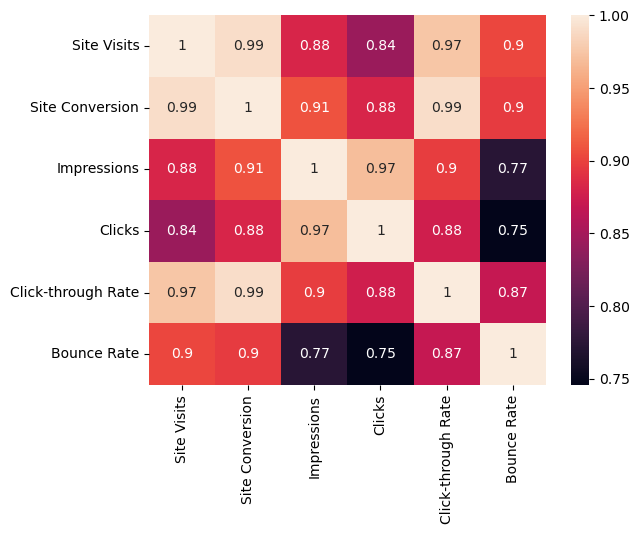

In [48]:
dataframe_website_traffic_data=dataframe[["Site Visits","Site Conversion","Impressions","Clicks","Click-through Rate","Bounce Rate"]]
#First Step is to plot heat map to check correlation between different variables
sns.heatmap(dataframe_website_traffic_data.corr(),  annot=True)

**Findings**:
* There is a strong positive relationship between:
<br>a. Click Through Rate & Site Conversion
<br>b. Site Visits & Site Conversion  
It indicates that the website is highly appealing and there is a very high probability that Customer performs action on website once he reaches it whether by direct visit or through Ad Campaigns. 
* There is a strong positive relationship between:
<br>a. Impressions & Clicks
<br>It shows that Ad Channels have good rate target audience


* Plot Time Series Data of Site Visits,  Impressions and  Bounce Rate. The Reason for choosing only these three columns is that : a. Site Visits are highly correlated with Site Conversion and Click-Through Rate and they follow almost the same pattern. Also, Impressions and clicks and highly correlated and they follow almost the same patter. Since Plotted Features have different scales and no outliers so data is normalized to be able to compare them togethor. 

In [49]:
#dataframe_website_traffic_data.drop(columns=["Site Conversion","Click-through Rate","Clicks"],inplace=True)
normalized_df=(dataframe_website_traffic_data-dataframe_website_traffic_data.min())/(dataframe_website_traffic_data.max()-dataframe_website_traffic_data.min())

* **Site Visits vs Bounce Rate**

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataframe["Start Date"], y=normalized_df["Site Visits"],mode='lines',name='Site Visits'))
fig.add_trace(go.Scatter(x=dataframe["Start Date"], y=normalized_df["Bounce Rate"],mode='lines',name='Bounce Rate'))
fig.update_xaxes(title_text="Date")
fig.show()

* **Site Visits vs Impressions**

In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataframe["Start Date"], y=normalized_df["Site Visits"],mode='lines',name='Site Visits'))
fig.add_trace(go.Scatter(x=dataframe["Start Date"], y=normalized_df["Impressions"],mode='lines',name='Impressions'))
fig.update_xaxes(title_text="Date")
fig.show()

**Findings**:
1. The curve of both Site Visits and Bounce Rate is meaningful by observing the difference between both metrics and not each metric solely. At the beginning of year, Bounce Rate is equal or less than site visits. By Mid Year, bounce rate exeeds Site Visits(Probably, a change happened in this period and needs to be investigated). By end of year, Site Visits Rate returned back again to exceed Bounce Rate.
2. The same for the curve of Site Visits and Impressions. Impressions start at a lower Rate than Site Visits then then start to become alligned towards end of year which indicates a change in the marketing campaign at this time that is worth investigating. 



## c. Hypothesis Testing

* Check Variables are Normally Distributed

In [52]:
def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    if p_value_normality <0.05:
        print("Reject null hypothesis So data is not normally distributed")
    else:
        print("Fail to reject null hypothesis So data is normally distributed")       

* Check both Variables have the same variance

In [53]:
def check_variance_homogeneity(group1, group2):
    test_stat_var, p_value_var= stats.levene(group1,group2)
    if p_value_var <0.05:
        print("Reject null hypothesis So variances of the samples are different.")
    else:
        print("Fail to reject null hypothesis So variances of the samples are same.")

* We will work on the normalized version of the data because Revenue and Cost of Goods both have different Ranges

### Hypothesis One

**Hypothesis Claim** : Increase in  Cost of Goods increases the Revenues. We will work on nomralized data because Revenue and Cost of Goods have different ranges

In [54]:
hypothesis_data=dataframe[["COGS","Revenue"]]
#Normalized Dataframe
normalized_df=(hypothesis_data-hypothesis_data.min())/(hypothesis_data.max()-hypothesis_data.min())

**Defining Hypothesis**:
1. Data is from two groups (Revenue,Cost of Goods)
2. Data is Unpaired 
3. <br> **H_0 : U_1_COGS <= U_2_Rev**   (Mean of COGS is Smaller than or equal Mean of Revenue)
   <br> **H_1 : U_1_COGS > U_2_Rev**    (Mean of COGs is Greater than  Mean of Revenue)


**Assumption Check**:
1. Data is Normally Distributed
2. Variance of Samples are the same

In [55]:
Cost_of_Goods=list(normalized_df["COGS"].values)
Revenues=list(normalized_df["Revenue"].values)

In [56]:
check_normality(Cost_of_Goods)
check_normality(Revenues)

Reject null hypothesis So data is not normally distributed
Reject null hypothesis So data is not normally distributed


**Note** : From the above, we find that the data is unpaired

**Select Proper Test**
<br> Since data isn't normally distributed so we use Non-Parameteric Version of the test  

In [57]:
ttest,pvalue = stats.mannwhitneyu(Cost_of_Goods,Revenues, alternative="two-sided")
if pvalue <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Fail to reject null hypothesis


**Decision & Conclusion**
<br> Since we fail to reject null hypothesis so there is no statistical evidence of association of Cost of Goods with Revenue

### Hypothesis Two

**Hypothesis Claim**: Increase in Ad Cost increases number of Sold Products 

In [58]:
hypothesis_data=dataframe[["Ad Cost","Units Sold"]]
#Normalized Dataframe
normalized_df=(hypothesis_data-hypothesis_data.min())/(hypothesis_data.max()-hypothesis_data.min())

**Defining Hypothesis**:
1. Data is from two groups (Ad Cost,Units Sold)
2. Data is Unpaired 
3. <br> **H_0 : U_1_Ad_Cost >= U_2_Units_Sold**   (Mean of Ad Cost is greater than or equal Mean of Units Sold)
   <br> **H_1 : U_1_Ad_Cost < U_2_units_Sold**    (Mean of Ad Cost is less than Mean of Units Sold)

**Assumption Check**:
1. Data is Normally Distributed 
2. Variance of Samples are the same

In [59]:
Ad_Cost=list(normalized_df["Ad Cost"].values)
Units_Sold=list(normalized_df["Units Sold"].values)

In [60]:
check_normality(Ad_Cost)
check_normality(Units_Sold)

Fail to reject null hypothesis So data is normally distributed
Fail to reject null hypothesis So data is normally distributed


In [61]:
check_variance_homogeneity(Ad_Cost, Units_Sold)

Fail to reject null hypothesis So variances of the samples are same.


**Select Proper Test**
<br> Since They are two groups, unpaired, data is normally distributed and variance of samples are the same so we will chooose 
Non-Parameteric  Version of the Test

In [62]:
ttest,p_value = stats.ttest_ind(Ad_Cost,Units_Sold)
if p_value <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis") 

Fail to reject null hypothesis


**Decision & Conclusion**
<br>Since we fail to reject null hypothesis so there is no statistical evidence of assocation of Ad Cost with Revenue so Ad Cost needs to be rechecked and directer towards better working channels.

## d. Data Visualization -- It is placed in Interactive Dashboard (Streamlit App)

## e. Recommendations

In [63]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataframe["Start Date"], y=dataframe["Units Sold"],mode='lines',name='Number of Sold Units'))
fig.update_layout(
    title=dict(text="Number of Sold Units")
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Number of Sold Units")
fig.show()

There are two types of recommendation:
* Recommendation based on the recommendation and investigation extracted from the above graphs and insights.
* Recommendation based on Common Featuers in Local Maximum points of number of sold units to be applied and execlude common features in Local minimum points of number of sold units


* Visitors Type

In [64]:
visitors_local_minimum=[]
visitors_local_maximum=[]
for x in range (0,len(dataframe)):
    if(x%2==0):
        visitors_type=dataframe.loc[x,"Visitor Type"]
        visitors_local_minimum.append(visitors_type)
    else:
        visitors_type=dataframe.loc[x,"Visitor Type"]
        visitors_local_maximum.append(visitors_type)

In [65]:
#Visitors Type Minimum
result_1=pd.DataFrame(visitors_local_minimum).value_counts()
result_1=result_1.to_frame(name="Count").reset_index()
result_1.rename(columns={0:"Visitors_Type"},inplace=True)
result_1["Type"]="Minimum"
#Visitors Type Maximum
result_2=pd.DataFrame(visitors_local_maximum).value_counts()
result_2=result_2.to_frame(name="Count").reset_index()
result_2.rename(columns={0:"Visitors_Type"},inplace=True)
result_2["Type"]="Maximum"
#Total
total=pd.concat([result_1,result_2],axis=0)

In [66]:
fig = px.bar(total, x="Visitors_Type", y="Count",
             color='Type', barmode='group',
             height=400)
fig.show()

The Audience type is equaly distributed among local maximum and minimum points so there is no statistical evidence of focusing
marketing campaing on a certain group will increase the sales.

* Discount Rate 

In [67]:
discounts_local_minimum=[]
discounts_local_maximum=[]
for x in range (0,len(dataframe)):
    if(x%2==0):
        discount_rate=dataframe.loc[x,"Discount Rate"]
        discounts_local_minimum.append(discount_rate)
    else:
        discount_rate=dataframe.loc[x,"Discount Rate"]
        discounts_local_maximum.append(discount_rate)

In [68]:
#Discounts Minimum
result_1=pd.DataFrame(discounts_local_minimum).value_counts()
result_1=result_1.to_frame(name="Count").reset_index()
result_1.rename(columns={0:"Discounts"},inplace=True)
result_1["Type"]="Minimum"
#Discounts Maximum
result_2=pd.DataFrame(discounts_local_maximum).value_counts()
result_2=result_2.to_frame(name="Count").reset_index()
result_2.rename(columns={0:"Discounts"},inplace=True)
result_2["Type"]="Maximum"
#Total
total=pd.concat([result_1,result_2],axis=0)

In [69]:
fig = px.bar(total, x="Discounts", y="Count",
             color='Type', barmode='group',
             height=400)
fig.show()

It is likely for local maximum points to have Common Feature Buy One Get one while on the other Side local minimum points have common feature of Free shipping while discounts lie in the second place with same number among both. Therefore , it is more preferred to give Buy One Get One discount to customers

* Shipping Cost

In [83]:
shipping_local_minimum=[]
shipping_local_maximum=[]
for x in range (0,len(dataframe)):
    if(x%2==0):
        shipping=dataframe.loc[x,"Shipping Cost"]
        shipping_local_minimum.append(shipping)
    else:
        shipping=dataframe.loc[x,"Shipping Cost"]
        shipping_local_maximum.append(shipping)

In [84]:
#Shipping Cost Minimum
result_1=pd.DataFrame(shipping_local_minimum).value_counts()
result_1=result_1.to_frame(name="Count").reset_index()
result_1.rename(columns={0:"Shipping"},inplace=True)
result_1["Type"]="Minimum"
#Shipping Cost Maximum
result_2=pd.DataFrame(shipping_local_maximum).value_counts()
result_2=result_2.to_frame(name="Count").reset_index()
result_2.rename(columns={0:"Shipping"},inplace=True)
result_2["Type"]="Maximum"
#Total
total=pd.concat([result_1,result_2],axis=0)

In [85]:
fig = px.bar(total, x="Shipping", y="Count",
             color='Type', barmode='group',
             height=400)
fig.show()

There is no  evidence on setting the shipping category in affecting the sales. Both Groups of Minimum and maximum local points are associated with moderate shipping price at the samoe count while local maximum points have relatively a higher portion among shipping category set to high.